In [1]:
import matplotlib.pyplot as plt
import numpy as np
from zlib import adler32
import requests
import networkx as nx
from scipy.stats import ks_2samp
import random
from sklearn.preprocessing import minmax_scale
import itertools

In [2]:
import json
from collections import Counter
with open('stats.txt', 'r') as f:
    d = json.load(f)

In [3]:
d

{'number_nodes': 1882,
 'radius': [15, 2],
 'diameter': [28, 4],
 'average_clustering': [0.005066798238955518, 0.001],
 'average_path_length': [11.748410823170731, 2],
 'number_cc': [168, 32],
 'degree_cdf': [[0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   19,
   21,
   24,
   46],
  [0.0,
   0.6902231668437833,
   0.8517534537725824,
   0.9086078639744952,
   0.9378320935175345,
   0.9516471838469713,
   0.9654622741764081,
   0.9723698193411264,
   0.9776833156216791,
   0.9808714133900106,
   0.9845908607863975,
   0.9888416578108395,
   0.9893730074388948,
   0.9925611052072264,
   0.9936238044633369,
   0.9952178533475027,
   0.9957492029755579,
   0.9968119022316685,
   0.997874601487779,
   0.9989373007438895,
   0.9994686503719448,
   1.0]]}

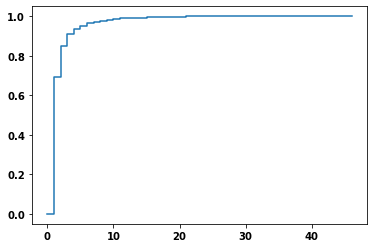

In [4]:
q_seq, p_seq = d['degree_cdf']
plt.plot(
    np.append(np.repeat(q_seq, 2)[1:], q_seq[-1]), 
    np.repeat(p_seq, 2)
)
plt.show()

In [5]:
density = [round(1882 * (p_seq[i+1] - p_seq[i])) for i in range(len(p_seq) - 1)]
degrees_input = {}
for i in range(len(density)):
    degrees_input[q_seq[i + 1]] = density[i]
degrees_input

{1: 1299,
 2: 304,
 3: 107,
 4: 55,
 5: 26,
 6: 26,
 7: 13,
 8: 10,
 9: 6,
 10: 7,
 11: 8,
 12: 1,
 13: 6,
 14: 2,
 15: 3,
 16: 1,
 17: 2,
 19: 2,
 21: 2,
 24: 1,
 46: 1}

In [7]:
edges_count = 0
for degree, count in degrees_input.items():
    edges_count += degree * count
print("Number of edges:", int(edges_count / 2))

Number of edges: 1740


In [7]:
print("Number of nodes:", d['number_nodes'])

Number of nodes: 1882


In [8]:
print("Average number of angles for one triangle:", 3 / d['average_clustering'][0])

Average number of angles for one triangle: 592.0898876404495


***Load graph***

In [9]:
G = nx.read_adjlist("output_great6.txt")

In [2]:
# degree_sequence_1 = []
# for node in range(d['number_nodes']):
#     r = random.random()
#     value = cdf[1][0]
#     for i, j in enumerate(cdf[1]):
#         if j < r:
#             value = cdf[0][i + 1]
#     degree_sequence_1.append(value)

In [3]:
# G1 = nx.Graph(nx.configuration_model(degree_sequence_1, create_using=nx.Graph))

In [4]:
# m = sum(degree_sequence_1) / d['number_nodes']

In [10]:
G_giant_1 = G.subgraph(max(nx.connected_components(G), key=len)).copy()

***BA***

In [11]:
def attach(node, G, m):
    bst = []
    for u, v in G.edges:                                      
        bst.append(u)
        bst.append(v)
    added_edges = 0
    while added_edges < m:
        v = random.choice(bst)
        if not G.has_edge(node, v):
            G.add_edge(node, v)
            added_edges += 1

def barabasi_albert_graph(n, m, random_seed=1):
    G = nx.star_graph(m)
    for i in range(1, n - m):
        attach(m + i, G, m)
    return G

In [76]:
G_ba = barabasi_albert_graph(d['number_nodes'], 2)

***SW***

In [60]:
def adjacent_edges(nodes, halfk):
    n = len(nodes)
    for i, u in enumerate(nodes):
        for j in range(i+1, i+halfk+1):
            v = nodes[j % n]
            yield u, v


def ring_lattice(n, k):
    G = nx.Graph()
    nodes = range(n)
    G.add_nodes_from(nodes)
    G.add_edges_from(adjacent_edges(nodes, k//2))
    return G

def watts_strogatz_graph(n, k, p):
    G = ring_lattice(n, k)
    for node in G.nodes:
        rewire(G, node, k, p)
    return G

def rewire(G, node, k, p):
    nodes = np.array(G.nodes)
    neighbour_nodes = list(G[node])[k//2:]
    for neighbour_node in neighbour_nodes:
        if random.random() >= p:
            continue
            
        G.remove_edge(node, neighbour_node)
        while True:
            new_node = random.choice(nodes)
            if not G.has_edge(node, new_node) and new_node != neighbour_node:
                G.add_edge(node, new_node)
                break

In [9]:
# G_sw = watts_strogatz_graph(n, 3, 0.95)
# G_giant_sw = G_sw.subgraph(max(nx.connected_components(G_sw), key=len)).copy()

In [11]:
# len(list(nx.connected_components(G_sw))), nx.average_clustering(G_giant_sw), nx.average_shortest_path_length(G_giant_sw), nx.radius(G_giant_sw), nx.diameter(G_giant_sw)

In [12]:
# len(list(G_sw.edges))

***Graphs combination***

***Finding the giant component iteratevely by Wattz-Strogatz graph***

In [206]:
# grid = {
#     'n': range(250, 400, 10),
#     'm': range(2, 5),
#     'p': range(5, 95, 5)
# }

grid = {
    'n': [250],
    'm': [2],
    'p': [0.6]
}


def find_params():
    for n in grid['n']:
        for m in grid['m']:
            for p in grid['p']:
                G1 = watts_strogatz_graph(n, m, p)
                G_giant_1 = G1.subgraph(max(nx.connected_components(G1), key=len)).copy()
                for i in range(100000):
                    G1 = watts_strogatz_graph(n, m, p)
                    G_giant_1 = G1.subgraph(max(nx.connected_components(G1), key=len)).copy()
                    if nx.radius(G_giant_1) == 15 and nx.diameter(G_giant_1) == 28 and (11.6 <= nx.average_shortest_path_length(G_giant_1) <= 11.8):
                        return G1, n, m, p, nx.radius(G_giant_1), nx.diameter(G_giant_1), len(G_giant_1.nodes), nx.average_clustering(G1), nx.average_shortest_path_length(G_giant_1)

ress = find_params()

In [207]:
G1 = ress[0].copy()

In [208]:
len(list(nx.connected_components(G1)))

13

In [209]:
G_giant_1 = G1.subgraph(max(nx.connected_components(G1), key=len)).copy()
print(f"Giant component stats: radius {nx.radius(G_giant_1)}, diameter {nx.diameter(G_giant_1)}, number of nodes: {len(G_giant_1.nodes)}, average shortest path length: {nx.average_shortest_path_length(G_giant_1)}")             

Giant component stats: radius 15, diameter 28, number of nodes: 210, average shortest path length: 11.744998860788334


In [210]:
degree_big_component = []
for item in G1.degree:
    degree_big_component.append(item[1])
degrees_dict_giant = dict(Counter(degree_big_component))

degrees_razn = {}
for key, value in degrees_input.items():
    degrees_razn[key] = value - degrees_dict_giant.get(key, 0)

degrees_razn

{1: 1221,
 2: 190,
 3: 68,
 4: 42,
 5: 21,
 6: 26,
 7: 13,
 8: 10,
 9: 6,
 10: 7,
 11: 8,
 12: 1,
 13: 6,
 14: 2,
 15: 3,
 16: 1,
 17: 2,
 19: 2,
 21: 2,
 24: 1,
 46: 1}

***Graph types***

***Star***

In [196]:
map_color = {
    1: 'yellow',
    2: 'orange',
    3: 'red',
    4: 'blue',
    5: 'green',
}

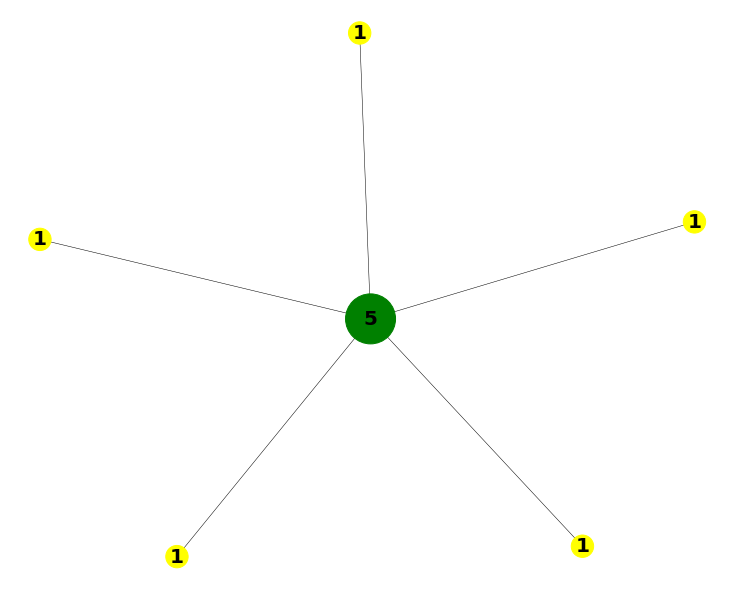

In [197]:
G_test = nx.star_graph(5)
plt.figure(figsize=(10, 8))
nx.draw(G_test, 
        width=0.5,
        node_size=[500 * x for x in list(dict(G_test.degree).values())],
        node_color=[map_color[x] for x in list(dict(G_test.degree).values())],
        labels=dict(G_test.degree),
        font_size=20)
plt.show()

***PATH***

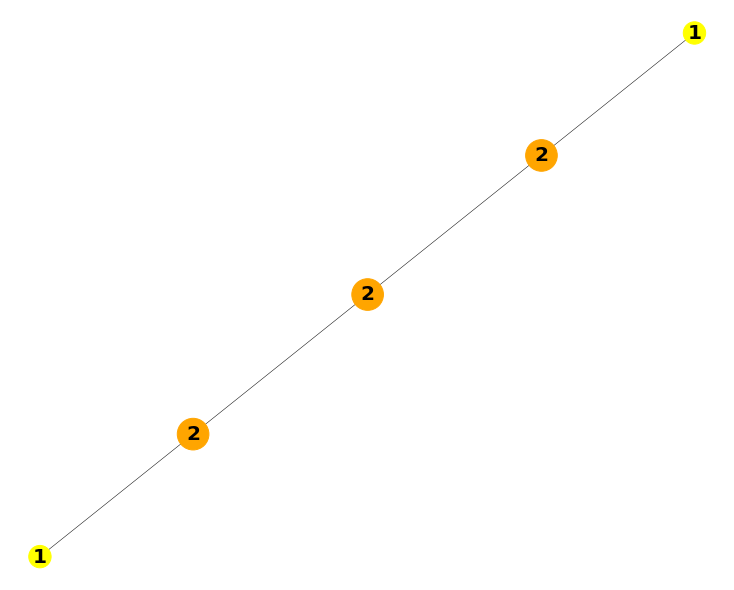

In [172]:
G_test = nx.path_graph(5)
plt.figure(figsize=(10, 8))
nx.draw(G_test, 
        width=0.5,
        node_size=[500 * x for x in list(dict(G_test.degree).values())],
        node_color=[map_color[x] for x in list(dict(G_test.degree).values())],
        labels=dict(G_test.degree),
        font_size=20)
plt.show()

***CYCLE***

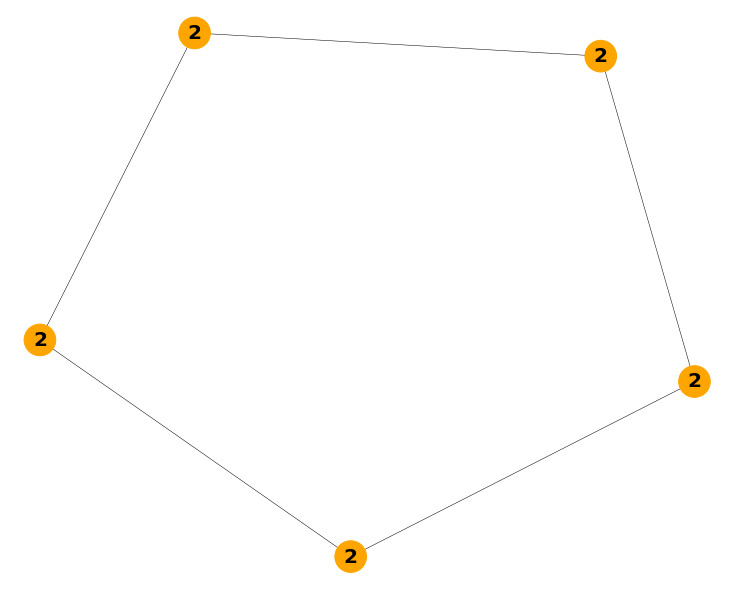

In [173]:
G_test = nx.cycle_graph(5)
plt.figure(figsize=(10, 8))
nx.draw(G_test, 
        width=0.5,
        node_size=[500 * x for x in list(dict(G_test.degree).values())],
        node_color=[map_color[x] for x in list(dict(G_test.degree).values())],
        labels=dict(G_test.degree),
        font_size=20)
plt.show()

***RING LATTICE 4***

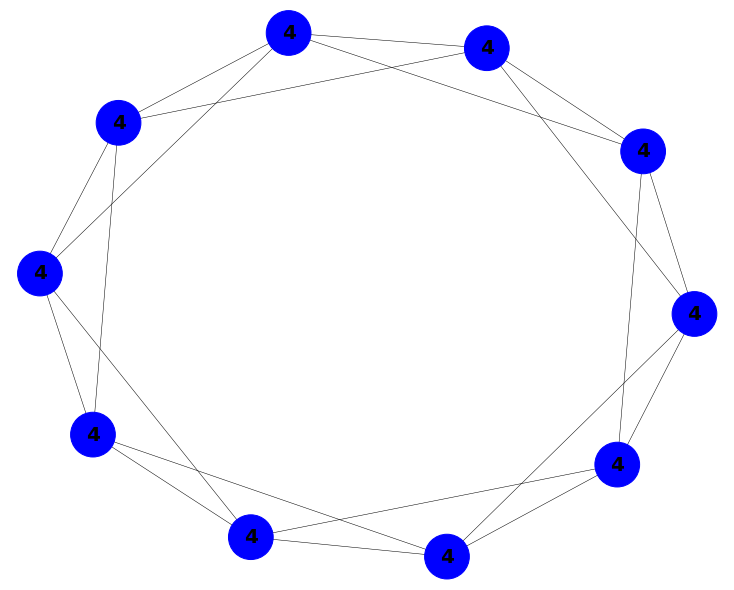

In [174]:
G_test = ring_lattice(10, 4)
plt.figure(figsize=(10, 8))
nx.draw(G_test, 
        width=0.5,
        node_size=[500 * x for x in list(dict(G_test.degree).values())],
        node_color=[map_color[x] for x in list(dict(G_test.degree).values())],
        labels=dict(G_test.degree),
        font_size=20)
plt.show()

***Necklace***

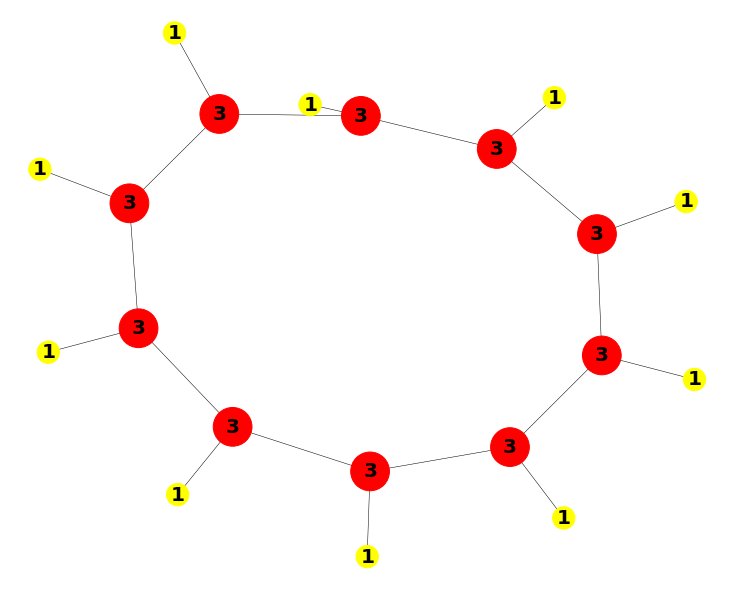

0.0

In [175]:
G_test = nx.cycle_graph(10)
number = 10
nds = list(G_test.nodes)
for node in nds:
    G_test.add_nodes_from([number])
    G_test.add_edge(node, number)
    number += 1

plt.figure(figsize=(10, 8))
nx.draw(G_test, 
        width=0.5,
        node_size=[500 * x for x in list(dict(G_test.degree).values())],
        node_color=[map_color[x] for x in list(dict(G_test.degree).values())],
        labels=dict(G_test.degree),
        font_size=20)
plt.show()
nx.average_clustering(G_test)

***Ring Lattice updated***

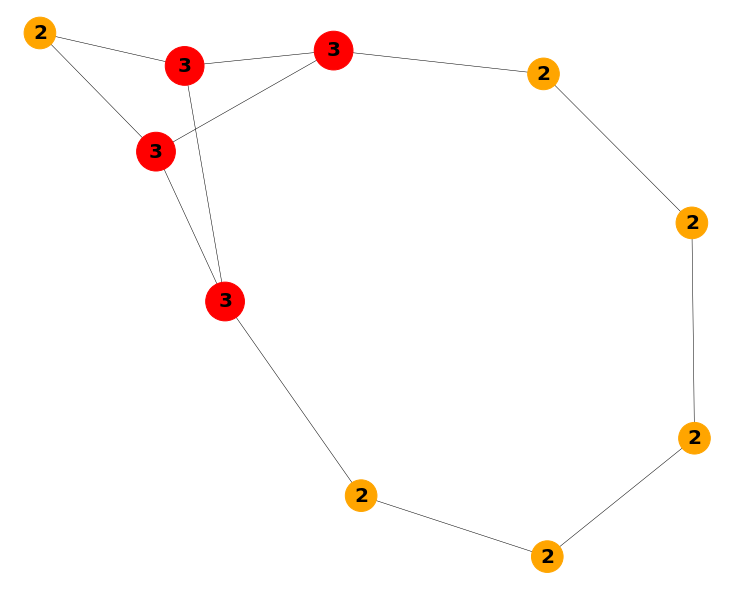

0.0

In [176]:
G_test = nx.cycle_graph(10)
number = 20
nds = list(G_test.nodes)
for _, node in enumerate(nds):
    if _ < 2:
        G_test.add_edge(node, (node + 3) % 10)
    
plt.figure(figsize=(10, 8))
nx.draw(G_test, 
        width=0.5,
        node_size=[500 * x for x in list(dict(G_test.degree).values())],
        node_color=[map_color[x] for x in list(dict(G_test.degree).values())],
        labels=dict(G_test.degree),
        font_size=20)
plt.show()
nx.average_clustering(G_test)

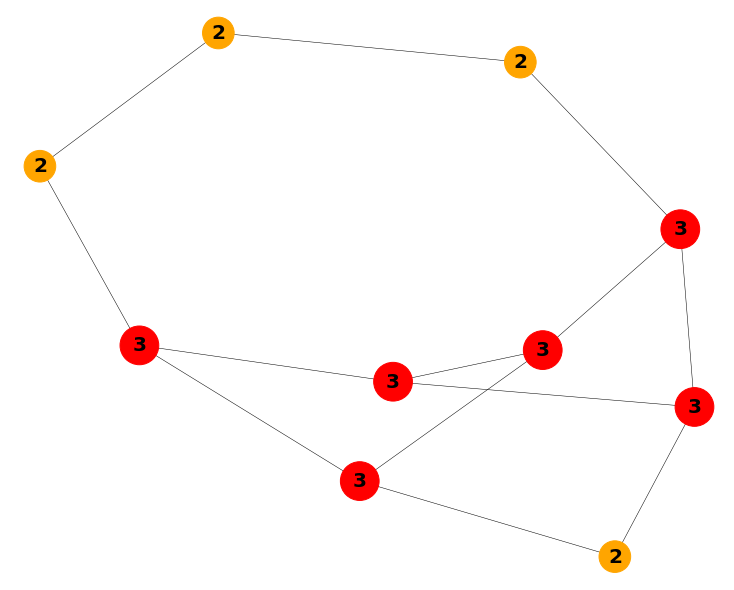

0.0

In [179]:
G_test = nx.cycle_graph(10)
number = 20
nds = list(G_test.nodes)
for _, node in enumerate(nds):
    if _ < 3:
        G_test.add_edge(node, (node + 6) % 10)
    
plt.figure(figsize=(10, 8))
nx.draw(G_test, 
        width=0.5,
        node_size=[500 * x for x in list(dict(G_test.degree).values())],
        node_color=[map_color[x] for x in list(dict(G_test.degree).values())],
        labels=dict(G_test.degree),
        font_size=20)
plt.show()
nx.average_clustering(G_test)

In [211]:
degree_big_component = []
for item in G1.degree:
    degree_big_component.append(item[1])
degrees_dict_giant = dict(Counter(degree_big_component))

degrees_razn = {}
for key, value in degrees_input.items():
    degrees_razn[key] = value - degrees_dict_giant.get(key, 0)

degrees_razn

{1: 1221,
 2: 190,
 3: 68,
 4: 42,
 5: 21,
 6: 26,
 7: 13,
 8: 10,
 9: 6,
 10: 7,
 11: 8,
 12: 1,
 13: 6,
 14: 2,
 15: 3,
 16: 1,
 17: 2,
 19: 2,
 21: 2,
 24: 1,
 46: 1}

In [8]:
# G1.degree
# G1.remove_node(249)

In [361]:
# G1.remove_node(249)
Gr_added = nx.relabel_nodes(G1, {i: 100000 + i for i in range(197)})
tt = 0
tt2 = 0
number = 1000
for key, value in degrees_razn.items():
    if key > 1:
        if key == 2:
            # Adding cycle for all nodes with degree 2
            gr = nx.relabel_nodes(nx.cycle_graph(201), {i: number + i for i in range(201)})
            number += 201
            nds = list(gr.nodes)
            for _, node in enumerate(nds):
                # Updating cycle node to updated lattice
                if _ < 5:
                    gr.add_edge(node, node + 13)
                # Updating cycle node to triangle              
                elif _ in [25, 29, 33, 37, 41, 45]:
                    gr.add_edge(node, node + 2)
            Gr_added = nx.compose(Gr_added, gr)
        elif key == 3:
            # Adding necklace graph for 3
            gr = nx.relabel_nodes(nx.cycle_graph(57), {i: number + i for i in range(57)})
            number += 57
            nds = list(gr.nodes)
            for _, node in enumerate(nds):  
                if _ < 46:
                    gr.add_node(number)
                    gr.add_edge(node, number)
                    number += 1
            Gr_added = nx.compose(Gr_added, gr)
        elif key >= 4:
            # Adding stars
            for _ in range(value):
                gr = nx.relabel_nodes(nx.star_graph(key), {i: number + i for i in range(key + 1)})
                number += (key + 1)
                Gr_added = nx.compose(Gr_added, gr)

In [362]:
subg = Gr_added.subgraph(max(nx.connected_components(Gr_added), key=len)).copy()
len(subg.nodes)

210

In [363]:
subg = Gr_added.subgraph(max(nx.connected_components(Gr_added), key=len)).copy()
len(list(nx.connected_components(Gr_added))), nx.average_clustering(Gr_added), nx.average_shortest_path_length(G_giant_1), nx.radius(G_giant_1), nx.diameter(subg)

(168, 0.005313496280552604, 11.744998860788334, 15, 28)

In [364]:
degrees_razn2 = {}
for key, value in degrees_input.items():
    degrees_razn2[key] = value - Counter(dict(Gr_added.degree).values()).get(key, 0)

degrees_razn2

{1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0,
 15: 0,
 16: 0,
 17: 0,
 19: 0,
 21: 0,
 24: 0,
 46: 0}

In [365]:
len(Gr_added.nodes)

1882

In [366]:
d['number_cc'][0] - len(list(nx.connected_components(Gr_added)))

0

In [368]:
nx.average_clustering(Gr_added)

0.005313496280552604

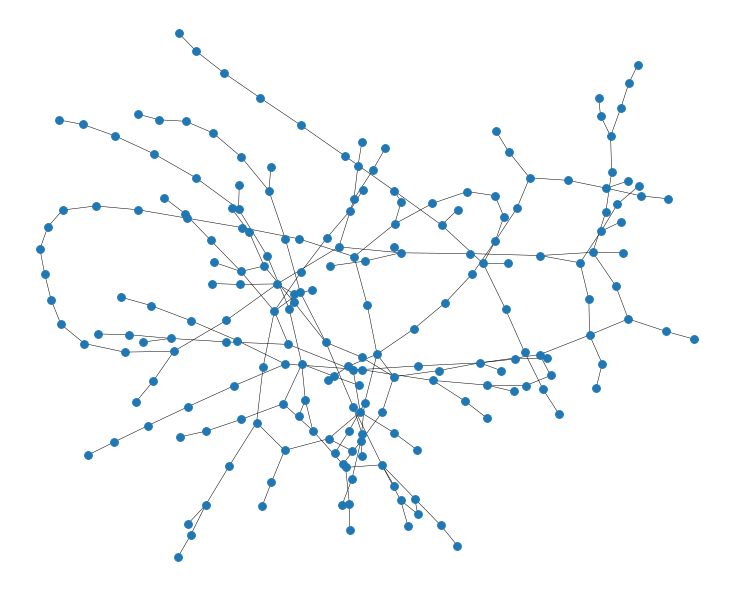

0.0

In [370]:
plt.figure(figsize=(10, 8))
nx.draw(subg, 
        width=0.5,
        node_size=60)
plt.show()
nx.average_clustering(gr)

In [1187]:
with open('output_great6.txt', 'w') as f_ou:
    for edge in Gr_added.edges:
        f_ou.write(' '.join(map(str, edge)) + '\n')